# Problem Set 2: Classification

To run and solve this assignment, one must have a working IPython Notebook installation. The easiest way to set it up for both Windows and Linux is to install [Anaconda](https://www.continuum.io/downloads). Then save this file to your computer (use "Raw" link on gist\github), run Anaconda and choose this file in Anaconda's file explorer. Use `Python 3` version. Below statements assume that you have already followed these instructions. If you are new to Python or its scientific library, Numpy, there are some nice tutorials [here](https://www.learnpython.org/) and [here](http://www.scipy-lectures.org/).

To run code in a cell or to render [Markdown](https://en.wikipedia.org/wiki/Markdown)+[LaTeX](https://en.wikipedia.org/wiki/LaTeX) press `Ctr+Enter` or `[>|]`(like "play") button above. To edit any code or text cell [double]click on its content. To change cell type, choose "Markdown" or "Code" in the drop-down menu above.

If a certain output is given for some cells, that means that you are expected to get similar results in order to receive full points (small deviations are fine). For some parts we have already written the code for you. You should read it closely and understand what it does.

Total: 100 points.

### 1. Logistic Regression

In this part of the exercise, you will build a logistic regression model to predict whether a student
gets admitted into a university.

Suppose that you are the administrator of a university department and you want to determine
each applicant’s chance of admission based on their results on two exams. You have historical
data from previous applicants in *ex2data1.txt* that you can use as a training set for logistic regression. For each
training example, you have the applicant’s scores on two exams and the admissions decision.

Your task is to build a classification model that estimates an applicant’s probability of admission based on the scores from those two exams. This outline and code framework will guide you through the exercise.

**1\.1 Implementation**

In [1]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
print('Tested with:')
print('Python', sys.version)
print({x.__name__: x.__version__ for x in [np, matplotlib]})

Tested with:
Python 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
{'numpy': '1.14.3', 'matplotlib': '2.2.2'}


**1.1.1 Visualizing the data**

Before starting to implement any learning algorithm, it is always good to visualize the data if possible. This first part of the code will load the data and display it on a 2-dimensional plot by calling the function plotData. The axes are the two exam scores, and the positive and negative examples are shown with different markers.

In [2]:
# it is good to isolate logical parts to avoid variables leaking into the
# global scope and messing up your logic later in weird ways

def read_classification_csv_data(fn, add_ones=False):
    # read comma separated data
    data = np.loadtxt(fn, delimiter=',')
    X_, y_ = data[:, :-1], data[:, -1, None]  # a fast way to keep last dim
    # while X_ is a (100,2) matrix and y_ is the label

    print(X_.shape, X_.min(), X_.max(), X_.dtype)
    print(y_.shape, y_.min(), y_.max(), y_.dtype)
    print("-------------------------")
    
    # insert the column of 1's into the "X" matrix (for bias)
    X = np.insert(X_, X_.shape[1], 1, axis=1) if add_ones else X_
    y = y_.astype(np.int32) # set the label to int
    return X, y
    
X_data, y_data = read_classification_csv_data('ex2data1.txt', add_ones=True)
print(X_data.shape, X_data.min(), X_data.max(), X_data.dtype)
print(y_data.shape, y_data.min(), y_data.max(), y_data.dtype)

(100, 2) 30.05882244669796 99.82785779692128 float64
(100, 1) 0.0 1.0 float64
-------------------------
(100, 3) 1.0 99.82785779692128 float64
(100, 1) 0 1 int32


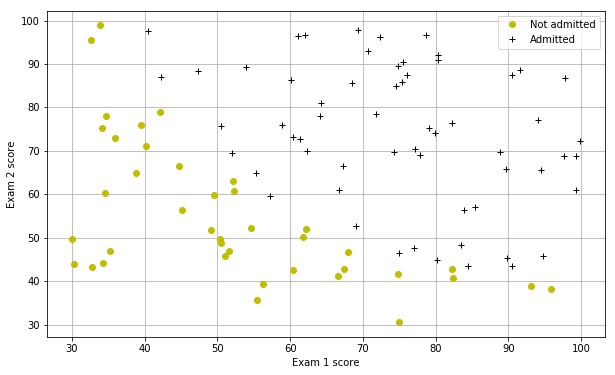

In [3]:
# how does the *X[y.ravel()==1, :2].T trick work?
# https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists

def plot_data(X, y, labels, markers, xlabel, ylabel, figsize=(10, 6), ax=None):
    if figsize is not None:
        plt.figure(figsize=figsize)

    ax = ax or plt.gca()
    for label_id, (label, marker) in enumerate(zip(labels, markers)):        
        ax.plot(*X_data[y_data.ravel()==label_id, :2].T, marker, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.legend()
    ax.grid(True)
    
student_plotting_spec = {
    'X': X_data,
    'y': y_data, 
    'xlabel': 'Exam 1 score', 
    'ylabel': 'Exam 2 score',
    'labels': ['Not admitted', 'Admitted'], 
    'markers': ['yo', 'k+'], 
    'figsize': (10, 6)
}
    
plot_data(**student_plotting_spec)
plt.show()

**1.1.2 [5pts] Sigmoid function** 

Before you start with the actual cost function, recall that the logistic regression hypothesis is defined as:

$h_\theta(x) = g(\theta^Tx)$

where function g is the sigmoid function. The sigmoid function is defined as:

$g(z) = \dfrac{1}{1+e^{-z}}$

Your first step is to implement/find a sigmoid function so it can be called by the rest of your program. Your code should also work with vectors and matrices. For a matrix, your function should perform the sigmoid function on every element. 

When you are finished, (a) plot the sigmoid function, and (b) test the function with a scalar, a vector, and a matrix. For scalar large positive values of x, the sigmoid should be close to 1, while for scalar large negative values, the sigmoid should be close to 0. Evaluating sigmoid(0) should give you exactly 0.5.

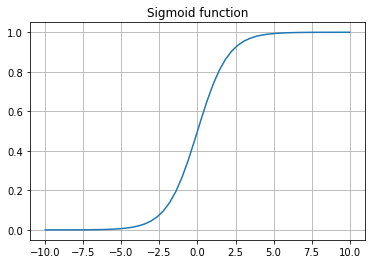

(50,) (49,)


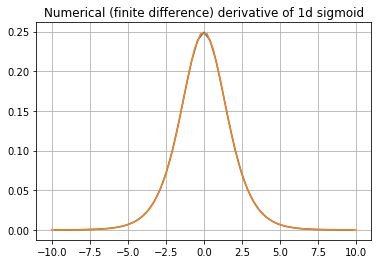

In [4]:
# check out scipy.special for great variaty of vectorized functions
# remember that sigmoid is the inverse of logit function
# maybe worth checking out scipy.special.logit first

def sigmoid(z):
    sigmoid = 1./(1+np.exp(-z))
    return sigmoid
#sigmoid = None

def check_that_sigmoid_f(f):
    # don't use np.arange with float step because it works as
    # val_{i+1} = val_i + step while val_i < end
    # what might do wrong with float precision?
    x_test = np.linspace(-10, 10, 50)
    sigm_test = f(x_test)
    plt.plot(x_test, sigm_test)
    plt.title("Sigmoid function")
    plt.grid(True)
    plt.show()
    
    # why should analytical_diff almost== finite_diff for sigmoid?
    analytical_diff = sigm_test*(1-sigm_test)
    finite_step = x_test[1]-x_test[0]
    finite_diff = np.diff(sigm_test) / finite_step
    print(x_test.shape, finite_diff.shape)
    plt.plot(x_test[:-1]+finite_step/2, finite_diff)
    plt.plot(x_test, analytical_diff)
    plt.title("Numerical (finite difference) derivative of 1d sigmoid")
    plt.grid(True)
    plt.show()
    
    
check_that_sigmoid_f(sigmoid)

**1.1.3 [15pts] Cost function and gradient**

Now you will implement the cost function and gradient for logistic regression. Complete the code
in the functions *hyposesis_function* and *binary_logistic_loss* below to return the value of the hypothesis function and the cost, respectively. Recall that the cost function in logistic regression is

$j(\theta) \ = \ \frac{1}{m} \ \sum_{i=1}^{m} \ [ \ -y^{(i)} log(h_\theta(x^{(i)})) \ - \ (1 - y^{(i)})log(1-h_\theta(x^{(i)})) \ ]$

and the gradient of the cost is a vector of the same length as $\theta$ where the $j^{th}$ element (for $j = 0, 1,...,n$) is defined as follows:

$\frac{\partial J(\theta)}{\partial \theta_{j}} \ = \ \frac{1}{m} \ \sum_{i=1}^{m} \ (h_\theta(x^{(i)})-y^{(i)}) x_j^{(i)}$

where $m$ is the number of points and $n$ is the number of features. Note that while this gradient looks identical to the linear regression gradient, the formula is
actually different because linear and logistic regression have different definitions of $h_\theta(x)$.

What should be the value of the loss for $\theta = \bar 0$ regardless of input? Why? Make sure your code also outputs this value.

In [5]:
# we are trying to fit a function that would return a 
# "probability of "

# hyposesis_function describes parametric family of functions that we are
# going to pick our "best fitting function" from. It is parameterized by
# real-valued vector theta, i.e. we are going to pick
#    h_best = argmin_{h \in H} logistic_loss_h(x, y, h)
# but because there exist a bijection between theta's and h's it is 
# eqvivalent to choosing
#    theta_best = argmin_{theta \in H} logistic_loss_theta(x, y, theta)

def hyposesis_function(x, theta):
    #raise NotImplementedError('Implement it yourself.')
    return sigmoid(np.matmul(x,theta))

# negative log likelihood of observing sequence of integer
# y's given probabilities y_pred's of each Bernoulli trial
# recommentation: convert both variables to float's 
# or weird sign stuff might happen like -1*y != -y for uint8
# use np.mean and broadcasting
def binary_logistic_loss(y, y_pred):
    assert y_pred.shape == y.shape
    #raise NotImplementedError('Implement it yourself.')
    #loss = (1/y.shape)*((-y) * np.log(y_pred)-(np.ones-y) * (1-np.log(y_pred)))
    #print(y.shape)
    loss = (1/y.shape[0])*np.linalg.norm((np.matmul(-y.T,np.log(y_pred))-np.matmul((1-y).T,np.log(1-y_pred))))
    return loss
    

def logistic_loss_theta_grad(x, y, h, theta):
    y_pred = h(x, theta)
    point_wise_grads = (y_pred - y)*x
    grad = np.mean(point_wise_grads, axis=0)[:, None]
    assert grad.shape == theta.shape
    return grad
    

def logistic_loss_theta(x, y, h, theta):
    return binary_logistic_loss(y, h(x, theta))

In [6]:
# Check that with theta as zeros, cost is about 0.693:
theta_init = np.zeros((X_data.shape[1], 1))
print(logistic_loss_theta(X_data, y_data, hyposesis_function, theta_init))
print(logistic_loss_theta_grad(X_data, y_data, hyposesis_function, theta_init))

0.6931471805599452
[[-12.00921659]
 [-11.26284221]
 [ -0.1       ]]


**1.1.4 Learning parameters using *fmin***

In the previous assignment, you found the optimal parameters of a linear regression model by
implementing gradient descent. You wrote a cost function and calculated its gradient, then took
a gradient descent step accordingly. This time, instead of taking gradient descent steps, you will
use a scipy.optimize built-in function called *fmin*.

The final $\theta$ value will then be used to plot the
decision boundary on the training data, as seen in the figure below.

In [7]:
import climin
from functools import partial

In [8]:
def optimize(theta_init, loss, loss_grad, max_iter=10000, print_every=1000, optimizer_fn=None, show=False):
    theta = theta_init.copy() 
    opt_args = (theta, loss_grad)
    
    if optimizer_fn is None:
        optimizer_fn = partial(climin.GradientDescent, step_rate=1e-3, momentum=0.999)

    optimizer = optimizer_fn(*opt_args)
    
    loss_curve = []
    for opt_info in optimizer:
        n_iter = opt_info['n_iter']
        f_value = loss(theta)
        loss_curve.append(f_value)

        if print_every != 0 and n_iter % print_every == 0:
            print(n_iter, f_value)

        if n_iter == max_iter:
            break
    
    if show:
        plt.plot(loss_curve)
        plt.show()
    
    return theta, f_value

1000 0.23235492534490954
2000 0.20707436313672026
3000 0.20892645351895361
4000 0.20969077333394062
5000 0.20887886801989006
6000 0.20707752314457167
7000 0.20570984825360505
8000 0.2047598627173496
9000 0.20415401062681077
10000 0.20381418595046077


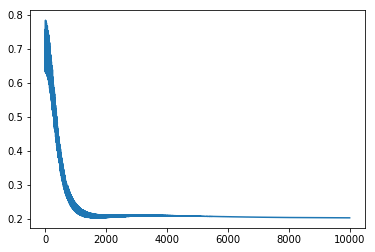

0.20381418595046077


In [9]:
theta_init = np.zeros((3, 1))
loss = partial(logistic_loss_theta, X_data, y_data, hyposesis_function)
loss_grad = partial(logistic_loss_theta_grad, X_data, y_data, hyposesis_function)
theta, best_cost = optimize(theta_init, loss, loss_grad, show=True)
print(best_cost)

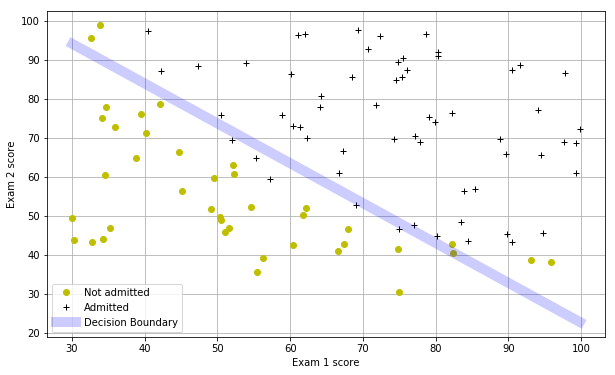

In [10]:
# Plotting the decision boundary: two points, draw a line between
# Decision boundary occurs when h = 0, or when
# theta_0*x1 + theta_1*x2 + theta_2 = 0
# y=mx+b is replaced by x2 = (-1/theta1)(theta2 + theta0*x1)

line_xs = np.array([np.min(X_data[:,0]), np.max(X_data[:,0])])
line_ys = (-1./theta[1])*(theta[2] + theta[0]*line_xs)
plot_data(**student_plotting_spec)
plt.plot(line_xs, line_ys, 'b-', lw=10, alpha=0.2, label='Decision Boundary')
plt.legend()
plt.show()

**1.1.5 [15pts] Evaluating logistic regression**

After learning the parameters, you can use the model to predict whether a particular student will
be admitted. 

(a) [5 pts] Show that for a student with an Exam 1 score of 45 and an Exam 2 score of 85, you should
expect to see an admission probability of 0.776.

Another way to evaluate the quality of the parameters we have found is to see how well the
learned model predicts on our training set. 

(b) [10 pts] In this part, your task is to complete the code in
*makePrediction*. The predict function will produce “1” or “0” predictions given a dataset and a learned
parameter vector $\theta$. After you have completed the code, the script below will proceed to report the
training accuracy of your classifier by computing the percentage of examples it got correct. You
should also see a Training Accuracy of 89.0. 

In [11]:
# For a student with an Exam 1 score of 45 and an Exam 2 score of 85, 
# you should expect to see an admission probability of 0.776.
check_data = np.array([[45., 85., 1]])
print(check_data.shape)
print(hyposesis_function(check_data, theta))  
# The sigmoid function gives the probability of enrollment, which is from 0 to 1. The theta is trained already by optimize().

(1, 3)
[[0.78755263]]


In [12]:
# use hyposesis function and broadcast compare operator
def predict(x, theta):
    #raise NotImplementedError('Implement it yourself.')
    hypo = (hyposesis_function(x,theta)> 0.5 ).astype(int)
    return hypo

def accuracy(x, y, theta):
    #raise NotImplementedError('Implement it yourself.')
    num = 0
    for i in range(y.shape[0]):
        if predict(x,theta)[i,:] == y[i,:]:
            num += 1
    return num/y.shape[0]
    
print(accuracy(X_data, y_data, theta))


0.9


### 2. Regularized logistic regression

In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant pass quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly. Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips in *ex2data2.txt*, from which you can build a logistic regression model.

**2.1 Visualizing the data**

Similar to the previous parts of this exercise, plotData is used to generate the figure below,
where the axes are the two test scores, and the positive (y = 1, accepted) and negative (y = 0,
rejected) examples are shown with different markers.

The figure below shows that our dataset cannot be separated into positive and negative examples by a
straight line. Therefore, a straightforward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.


In [13]:
X_data_, y_data = read_classification_csv_data('ex2data2.txt')
X_data = X_data_ - X_data_.mean(axis=0)[None, :]
print(X_data.shape, X_data.min(), X_data.max(), X_data.dtype)
print(y_data.shape, y_data.min(), y_data.max(), y_data.dtype)

(118, 2) -0.83007 1.1089 float64
(118, 1) 0.0 1.0 float64
-------------------------
(118, 2) -0.9528415593220338 1.0161210915254237 float64
(118, 1) 0 1 int32


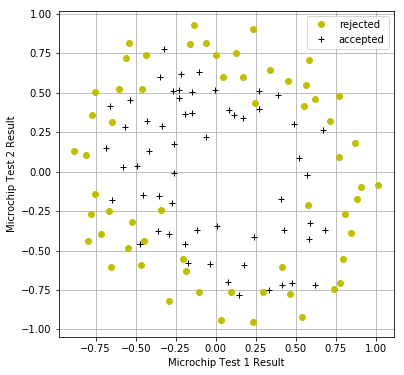

In [14]:
chip_plotting_spec = {
    'X': X_data,
    'y': y_data, 
    'xlabel': 'Microchip Test 1 Result', 
    'ylabel': 'Microchip Test 2 Result',
    'labels': ['rejected', 'accepted'], 
    'markers': ['yo', 'k+'],
    'figsize': (6, 6)
}

plot_data(**chip_plotting_spec)
plt.show()

**2.2 Nonlinear feature mapping**

One way to fit the data better is to create more features from each data point. In *mapFeature* below, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the
sixth power as follows:

\begin{equation}
mapFeature(x) \ = \
\begin{bmatrix}
    1 \\
    x_1 \\
    x_2 \\
    x_1^2 \\
    x_1x_2 \\
    x_2^2 \\
    x_1^3 \\
    \vdots \\
    x_1x_2^5 \\
    x_2^6 \\
\end{bmatrix}
\end{equation}

As a result of this mapping, our vector of two features (the scores
on two QA tests) has been transformed into a 28-dimensional
vector. A logistic regression classifier trained on this
higher-dimension feature vector will have a more complex
decision boundary and will appear nonlinear when drawn in our
2-dimensional plot.
While the feature mapping allows us to build a more expressive
classifier, it is also more susceptible to overfitting. In the next parts
of the exercise, you will implement regularized logistic regression
to fit the data and also see for yourself how regularization can help combat the overfitting problem.

Either finite dimentional (or even infinite-dimentional, as you would see in the SVM leacture and the corresponding home assingment) feature mappings are usually denoted by $\Phi$ and therefore our hyposesis is now that the Bernoulli probability of chip matfunctioning might be described as

$$ p_i = \sigma(\Phi(x_i)^T \theta)$$

In [15]:
from itertools import combinations_with_replacement

def polynomial_feature_map(X_data, degree=20, show_me_ur_powers=False):
    assert len(X_data.shape) == 2
    group_size = X_data.shape[1]
    assert group_size == 2
    # hm.. how to get all ordered pairs (c, d) of non-negative ints 
    # such that their sum is c + d <= dergee? 
    # it is eqvivalent to getting all groups of integers (a, b) such that
    # 0 <= a <= b <= degree and definintg c = a, d = b - a
    # their sum is below degree, both are >= 0 
    # then feature_i = (x_0 ^ c) * (x_1 ^ d)
    comb_iterator = combinations_with_replacement(range(degree+1), group_size)
    not_quite_powers = np.array(list(comb_iterator))
    # The not_quite_powers here is all pairs combinations of powers from (0,0) to (20,20)
    powers_bad_order = not_quite_powers.copy()
    powers_bad_order[:, 1] -= not_quite_powers[:, 0]
    # Here the pairs in "powers_bad_order" array has sums no larger than 20.
    # let's reorder them so that lower power monomials come first
    rising_power_idx = np.argsort(powers_bad_order.sum(axis=1))
#     print(rising_power_idx.shape)  #(231,)
#     print(powers_bad_order.shape)  #(231,2)
    powers = powers_bad_order[rising_power_idx]
#     print(powers.shape)  # (231,2)
    # the "powers" is the sortedd powers of pairs. from 0 to 20.
    if show_me_ur_powers is True:
        print(powers.T)  # shape is (2,231)
        print('total power per monomial', powers.sum(axis=1))  # shape is (231,)
    X_with_powers = np.power(X_data[:, :, None], powers.T[None])
#     print(X_with_powers.shape) # shape is (118,2,231)
    X_poly = np.prod(X_with_powers, axis=1)  # return the product of array elements over a given axis(column)
    return X_poly

X_pf = polynomial_feature_map(X_data, show_me_ur_powers=True)
print(X_pf.shape)  # so that we expand the input matrix from (118,2) ----- (118,231)

[[ 0  0  1  0  2  1  0  2  3  1  4  2  1  3  0  5  3  0  2  4  1  0  6  2
   5  4  3  1  4  0  1  2  6  7  3  5  2  3  4  6  8  5  7  0  1  4  7  3
   6  9  8  0  2  1  5  9  3  5  7  8  4 10  6  1  0  2  0  9  1  4  5  2
  10  7  8  6 11  3  7  0  1  9 12  4  6  2  8 11 10  3  5  6 13  1  5  7
   9  8  4 12  2 10  0 11  3  0 12 11 14 10  9  7  6  8 13  4  2  3  1  5
   5  4  9  0 15 14  7  1 10  8  3  2 11  6 12 13  8  3 11  2 14  9 12 13
  10 16  4  0  6  5  1 15  7 12  5  2 13 11  6 15  3 10  7  0  1 16 14  8
   4  9 17  5 12  2  4  8 14 13 16 11  9  6 15  0  1 10  3 18  7 17 15 13
  14 17 19 18 16  2 12  3  1  4  5  0  7  8  6  9 10 11 11 18  3  1 17 10
   4 16 13  5  0 19 15 12  6  9  7 14  2  8 20]
 [ 0  1  0  2  0  1  3  1  0  2  0  2  3  1  4  0  2  5  3  1  4  6  0  4
   1  2  3  5  3  7  6  5  1  0  4  2  6  5  4  2  0  3  1  8  7  5  2  6
   3  0  1  9  7  8  4  1  7  5  3  2  6  0  4  9 10  8 11  2 10  7  6  9
   1  4  3  5  0  8  5 12 11  3  0  8  6 10  4  1  2  9  7  7  0

**2.3 Cost function and gradient**

Now you will implement code to compute the cost function and gradient for regularized logistic
regression. Recall that the regularized cost function in logistic regression is:

$J(\theta) \ = \ [ \ \frac{1}{m} \ \sum_{i=1}^{m} \ [ \ -y^{(i)} log(h_\theta(x^{(i)})) \ - \ (1 - y^{(i)})log(1-h_\theta(x^{(i)})) \ ] \ ] \ + \frac{\lambda}{2m} \sum_{j=2}^{n} \theta_j^2 $

Note that you should not regularize the parameter $\theta_0$ (Why not? Think about why that would be a bad idea).

The gradient of the cost function is a vector where the j element is defined as follows (you should understand how to obtain this expression):

$\frac{\partial J(\theta)}{\partial \theta_{0}} \ = \ \frac{1}{m} \ \sum_{i=1}^{m} \ (h_\theta(x^{(i)})-y^{(i)}) x_j^{(i)} \quad \quad \quad \quad \quad \quad$ for $\quad j=0$

$\frac{\partial J(\theta)}{\partial \theta_{j}} \ = \ (\frac{1}{m} \ \sum_{i=1}^{m} \ (h_\theta(x^{(i)})-y^{(i)}) x_j^{(i)}) + \frac{\lambda}{m}\theta_j \quad \quad \quad$ for $\quad j \ge 1$


**2.3.1 [10pts] Implementing regularized logistic regression**

Re-implement computeCost with regularization.

In [33]:
# Cost function, default lambda (regularization) 0
def logistic_loss_theta_w_reg(x, y, h, theta, lambda_=0.0): 
    #raise NotImplementedError('Implement it yourself.')
    loss = (1/x.shape[0])*np.linalg.norm((-np.matmul(y.T,np.log(h(x,theta)))-np.matmul((1-y).T,np.log(1-h(x,theta)))))+\
    (lambda_/(2*x.shape[0]))*(np.sum([i**2 for i in theta[1:]]))
    return loss

def logistic_loss_theta_w_reg_grad(x, y, h, theta, lambda_=0.0): 
    #raise NotImplementedError('Implement it yourself.')
    theta_new = theta.copy()
    theta_new[0] = 0
    grad = (1/x.shape[0])*np.matmul(x.T,(h(x,theta)-y))+(lambda_/x.shape[0])*theta_new
#     print((h(x,theta)-y).shape) # shape is (118,1)
#     print(x.shape)
#     print(theta.shape)
#     print(grad.shape)  # shape is (231,1)
    return grad

Once you are done, you will call your cost function using the initial value of
θ (initialized to all zeros). You should see that the cost is about 0.693. 

0.6931471805599453
[[ 8.47457627e-03]
 [-1.47393694e-03]
 [ 1.83238652e-02]
 [ 3.79204875e-02]
 [ 4.83116870e-02]
 [ 8.14194228e-03]
 [ 2.74281128e-03]
 [-2.78183863e-03]
 [ 1.02502549e-02]
 [ 2.53327158e-03]
 [ 3.62206863e-02]
 [ 1.14745376e-02]
 [-5.13006494e-04]
 [-7.37665567e-04]
 [ 2.96926570e-02]
 [ 9.66227378e-03]
 [ 1.26710268e-03]
 [ 5.83282025e-04]
 [-7.50311428e-04]
 [-2.66858278e-03]
 [ 1.96894912e-03]
 [ 2.22460292e-02]
 [ 2.61849067e-02]
 [ 5.14792073e-03]
 [-1.80202003e-03]
 [ 5.56307799e-03]
 [-1.21167516e-03]
 [-2.15775754e-03]
 [-7.77390798e-04]
 [-9.97158003e-04]
 [ 1.71369098e-03]
 [-6.27268614e-04]
 [-2.22430409e-03]
 [ 9.08105468e-03]
 [ 8.49610910e-04]
 [ 1.01196534e-03]
 [ 2.91086360e-03]
 [-1.05308072e-03]
 [ 2.03649298e-03]
 [ 3.01185527e-03]
 [ 1.95553205e-02]
 [-8.02388158e-04]
 [-1.74538564e-03]
 [ 1.70850907e-02]
 [-2.24318631e-03]
 [-4.29158120e-04]
 [ 7.52146991e-04]
 [ 5.96787640e-04]
 [-6.12485717e-04]
 [ 8.44926264e-03]
 [-1.72286617e-03]
 [-1.8530600

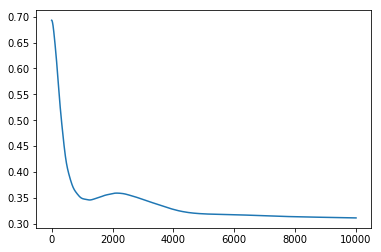

best loss 0.3113433794184657
best acc 0.847457627118644


In [34]:
theta_init = np.zeros((X_pf.shape[1], 1))
print(logistic_loss_theta_w_reg(X_pf, y_data, hyposesis_function, theta_init))
print(logistic_loss_theta_w_reg_grad(X_pf, y_data, hyposesis_function, theta_init))

loss = partial(logistic_loss_theta_w_reg, X_pf, y_data, hyposesis_function)
loss_grad = partial(logistic_loss_theta_w_reg_grad, X_pf, y_data, hyposesis_function)
theta, best_cost = optimize(theta_init, loss, loss_grad, max_iter=10000, print_every=0, show=True)
print('best loss', best_cost)
print('best acc', accuracy(X_pf, y_data, theta))

**2.3.2 [15pts] Learning parameters using *minimize***

You will use *optimize.minimize* to learn the optimal parameters $\theta$. If you
have completed the cost and gradient for regularized logistic regression correctly, you should be able to learn the parameters
$\theta$ using *minimize*. Implement the function *optimizeRegularizedTheta* below.  

In [18]:
def optimizeRegularizedTheta():
    theta,_ = optimize(theta_init, loss, loss_grad, max_iter=1000, print_every=0, show=False)
    return theta
theta_min = optimizeRegularizedTheta()
print(theta_min.shape)
print(theta_min)

(231, 1)
[[ 4.19339701e+00]
 [ 8.52370120e-02]
 [ 4.83000122e-01]
 [-5.71113682e+00]
 [-6.33415275e+00]
 [-4.85851307e+00]
 [-1.15482614e+00]
 [-3.93797616e-02]
 [ 5.88228313e-01]
 [ 5.58994006e-01]
 [-4.95595320e+00]
 [-1.77907328e+00]
 [-1.21835200e+00]
 [-7.36011170e-01]
 [-4.27322478e+00]
 [-5.88255852e-02]
 [ 2.23702992e-01]
 [-5.79127292e-01]
 [-1.84906486e-01]
 [ 1.46909611e-01]
 [ 1.35488891e-01]
 [-3.03590399e+00]
 [-3.49565671e+00]
 [-7.16125831e-01]
 [-3.51474543e-02]
 [-8.74099801e-01]
 [-7.04807426e-02]
 [-2.69920641e-01]
 [-5.07694793e-03]
 [-1.66430396e-01]
 [-9.20245749e-03]
 [-6.25079394e-02]
 [ 2.05407014e-01]
 [-3.33315099e-01]
 [ 3.32576094e-02]
 [ 2.26272922e-02]
 [-3.68022741e-01]
 [ 5.06708679e-02]
 [-2.95429610e-01]
 [-4.72926092e-01]
 [-2.47931934e+00]
 [ 4.43540734e-02]
 [ 1.23238091e-01]
 [-2.24395839e+00]
 [ 1.89579943e-02]
 [ 3.08343817e-03]
 [-3.42453812e-02]
 [-8.91670087e-03]
 [ 4.76865374e-02]
 [-4.26433497e-01]
 [ 1.79765157e-01]
 [ 5.84451249e-02]
 [ 

**2.4 Plotting the decision boundary**

To help you visualize the model learned by this classifier, we have provided the function
*plotBoundary* which plots the (non-linear) decision boundary that separates the
positive and negative examples. 

In [19]:
def plot_boundary(theta, X, y, labels, markers, xlabel, ylabel, figsize=(12, 10), ax=None):
    """
    Function to plot the decision boundary for arbitrary theta, X, y, lambda value
    Inside of this function is feature mapping, and the minimization routine.
    It works by making a grid of x1 ("xvals") and x2 ("yvals") points,
    And for each, computing whether the hypothesis classifies that point as
    True or False. Then, a contour is drawn with a built-in pyplot function.
    """
    ax = ax or plt.gca()
    x_range = np.linspace(-1,1.5,50)
    y_range = np.linspace(-1,1.5,50)
    xx, yy = np.meshgrid(x_range, y_range)
    X_fake = np.stack([xx, yy]).reshape(2, -1).T
    X_fake_fm = polynomial_feature_map(X_fake)
    y_pred_fake = hyposesis_function(X_fake_fm, theta)
    for label_id, (label, marker) in enumerate(zip(labels, markers)):        
        ax.plot(*X_data[y_data.ravel()==label_id, :2].T, marker, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.legend()
    plt.grid()
    return ax.contour( x_range, y_range, y_pred_fake.reshape(50, 50).T, [0.5])


def silent_optimize_w_lambda(lambda_):
    theta_init = np.zeros((X_pf.shape[1], 1))
    data = (X_pf_train, y_train, hyposesis_function)
    loss = partial(logistic_loss_theta_w_reg, *data, lambda_=lambda_)
    loss_grad = partial(logistic_loss_theta_w_reg_grad, *data, lambda_=lambda_)
    optimizer_fn = partial(climin.GradientDescent, step_rate=1e-4, momentum=0.999)
    theta, final_loss = optimize(
        theta_init, loss, loss_grad, optimizer_fn=optimizer_fn, 
        max_iter=1000, print_every=0, show=False
    )
    return theta, final_loss

**2.4.1 [10pts] Plot Decision Boundaries**

(a) [2 pts] Use *plotBoundary* to obtain four subplots of the decision boundary for the following values of the regularization parameter: $\lambda \ = \ 0, 1, 5, 10$

(b) [2 pts] Comment on which plots are overfitting and which plots are underfitting.

**Answer**

When $\lambda = 0$(no regularization), plot is overfitting. When $\lambda=5,10$, plots are underfitting.

(c) [2 pts] Which is the model with the highest bias? The highest variance?

**Answer**

When $\lambda=10$, the model has the highest bias. When $\lambda=0$, the model has the highest variance.

(d) [2 pts] What is another way to detect overfitting? 

**Answer**

There are two ways to detect overfitting.

(1) By cross-validation. If the model performes well on training data but bad on test data, overfitting. If the performances are both bad, under-fitting.

(2) By learning curve. If both validation accuracy and training accuracy converge at some low value, under-fitting. If both of them converge around a high value, but there is a huge gap between training acc and validation acc(training always performes better than validation), overfitting.

(e) [2 pts] Considering that later components of theta correspond to higher powers of monomials, plot values of theta and commend on effects of regularization

[(34, 231), (34, 1), (84, 231), (84, 1)]


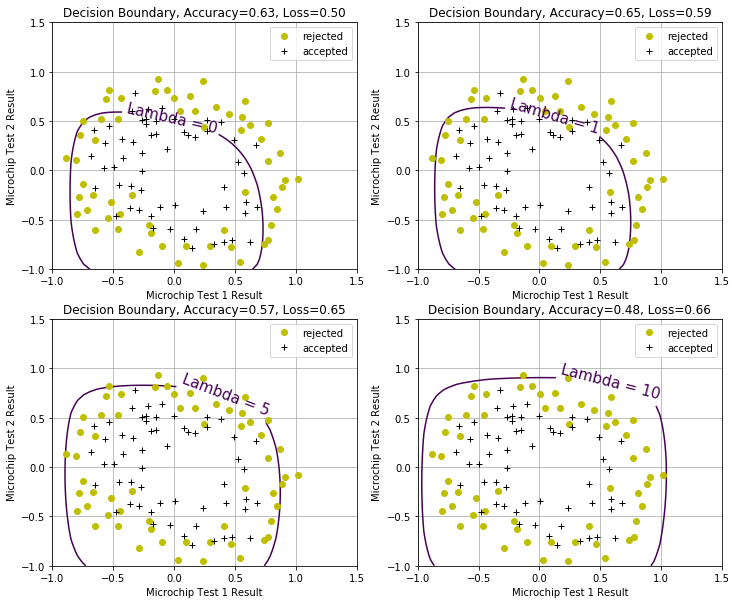

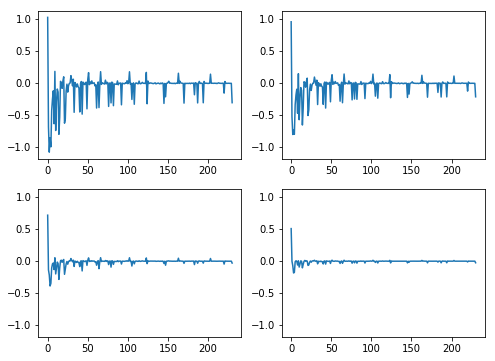

In [20]:
# (a) Build a figure showing contours for various values of regularization parameter, lambda

np.random.seed(2)
train_idx_mask = np.random.rand(X_pf.shape[0]) < 0.3
X_pf_train, y_train = X_pf[train_idx_mask], y_data[train_idx_mask]
X_pf_test, y_test = X_pf[~train_idx_mask], y_data[~train_idx_mask]
print([x.shape for x in (X_pf_train, y_train, X_pf_test, y_test)])


new_plotting_spec = {
    'X': X_data,
    'y': y_data, 
    'xlabel': 'Microchip Test 1 Result', 
    'ylabel': 'Microchip Test 2 Result',
    'labels': ['rejected', 'accepted'], 
    'markers': ['yo', 'k+'],
    'figsize': (12, 10) 
}

# you might find following lines useful:
#
#    cnt_fmt = {0.5: 'Lambda = %d' % lambda_}
#    ax.clabel(cnt, inline=1, fontsize=15, fmt=cnt_fmt)
# 
# red dots indicate training samples

thetas = []
final_loss = []
plt.figure(figsize=(12,10))
for id_, lambda_ in enumerate([0, 1, 5, 10]):
    theta, final_loss = silent_optimize_w_lambda(lambda_=lambda_)
    acc = accuracy(X_pf_test, y_test, theta)
    thetas.append(theta)
    ax = plt.subplot(2, 2, id_+1)
    cnt = plot_boundary(**new_plotting_spec, theta=theta, ax=ax)  
    cnt_fmt = {0.5: 'Lambda = %d' % lambda_}
    ax.clabel(cnt, inline=1, fontsize=15, fmt=cnt_fmt)
    plt.title('Decision Boundary, Accuracy={}, Loss={}'.format('%.2f' %acc,'%.2f' %final_loss))
plt.show()


# (e) [2 pts] Considering that later components of theta correspond to higher powers
# of monomials, plot values of theta and commend on effects of regularization
plt.figure(figsize=(8,6))
ax = None
for th_id, theta in enumerate(thetas):
    ax = plt.subplot(2, 2, th_id+1, sharey=ax)
    plt.plot(theta)
    
plt.show()

### 3. Written part

These problems are extremely important preparation for the exam. Submit solutions to each problem by filling the markdown cells below.

**3.1 [10pts]** Maximum likelihood for Logistic Regression

Showing all steps, derive the LR cost function using maximum likelihood. Assume that
the probability of y given x is described by:

$P(\ y=1 \; \vert \; x \ ; \ \theta \ ) = h_{\theta}(x)$ 

$P(\ y=0 \; \vert \; x \ ; \ \theta \ ) = 1 - h_{\theta}(x)$



**Answer**

$y^{(i)} \in {(0,1)}$ and $p(y=y^{(i)}|x_i,\theta)=h_{\theta}(x)^{y^{(i)}}(1 - h_{\theta}(x))^{1-y^{(i)}}$, which is a bernouli distribution.
$$ p(y=y^{(i)} |x,\theta)=\prod_{i=1}^{m}h_{\theta}(x)^{y^{(i)}}(1 - h_{\theta}(x))^{1-y^{(i)}}$$
Take $\log$ on both side, we will derive the logistic regression cost function using maximum likelihood:
$$ \log p(y=y^{(i)} |x,\theta) = \sum_{i=1}^{m}{y^{(i)}}\log(h_{\theta}(x))+(1-y^{(i)})\log(1 - h_{\theta}(x))$$
Therefore, the $J(\theta)$ would be,
$$ \mathbf {J(\theta)} = -\frac{1}{m}[\sum_{i=1}^{m}{y^{(i)}}\log(h_{\theta}(x))+(1-y^{(i)})\log(1 - h_{\theta}(x))]$$


**3.2 [10pts]** Logistic Regression Classification with Label Noise

Suppose you are building a logistic regression classifier for images of dogs, represented by a feature vector x, into one of two categories $y \in \{0,1\}$, where 0 is “terrier” and 1 is “husky.” You decide to use the logistic regression model $p(y = 1 \ \vert \ x) = h_{\theta}(x)=\sigma(\theta^Tx).$ You collected an image dataset **D**$\ = \{x^{(i)},t^{(i)}\}$, however, you were very tired and made
some mistakes in assigning labels $t^{(i)}.$ You estimate that you were correct in about $\tau$ fraction of all cases.

(a) Write down the equation for the posterior probability $p(t = 1 \ \vert \ x)$ of the label being 1 for some point x, in terms of the probability of the true class, $p(y = 1 \ \vert \ x).$

(b) Derive the modified cost function in terms of $\ \theta, x^{(i)},t^{(i)}$ and $\tau$.

**Answer**

**(a)**

y is the true label of two categories, which is $y \in \{0,1\}$. The t is the assign label, which is $t \in \{0,1\}$.
Because there are some mistakes in assigning labels $t^{(i)}$, so that there are 4 cases: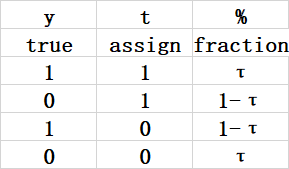

$$ p(t=1|x) = \tau p(y=1|x)+(1-\tau)p(y=0|x)$$
$$= \tau p(y=1|x)+(1-\tau)(1-p(y=1|x))$$
$$=1-\tau + (2\tau-1)\sigma(\theta^{T}x)$$
$$=1-\tau+(2\tau-1)\frac{1}{1+\exp(-\theta^{T}x)}$$

**(b)**

The modified cost function will not take $y^{(i)}$ as the label distribution parameter, instead, $t^{(i)}$ is used. The loss function w.r.t $\ \theta, x^{(i)},t^{(i)}$ and $\tau$ is:
$$ J'(\theta) = \frac{1}{m}\sum_{i=1}^{m}Cost(h_{\theta}(x^{(i)}),t^{(i)})$$
$$ = -\frac{1}{m}\sum_{i=1}^{m}t^{(i)}\log p(t=1|x^{(i)})+(1-t^{(i)})\log(1-p(t=1|x^{(i)}))$$
$$ = -\frac{1}{m}\sum_{i=1}^{m}t^{(i)}\log(1-\tau+\frac{2\tau-1}{1+\exp(-\theta^{T}x^{(i)})})+(1-t^{(i)})\log(\tau-\frac{2\tau-1}{1+\exp(-\theta^{T}x^{(i)})}))$$


**3.3 [10pts] Cross-entropy loss for multiclass classification**

This problem asks you to derive the cross-entropy loss for a multiclass classification problem using maximum likelihood.
Consider the multiclass classification problem in which each input is assigned to one of $K$ mutually exclusive classes. The binary target variables $y_k$ ∈ {0, 1} have a "one-hot" coding scheme, where the value is 1 for the indicated class and 0 for all others. Assume that we can interpret the network outputs as $h_k(x,\theta) = p(y_k = 1|x)$, or the probability of the kth class.

Show that the maximum likelihood estimate of the parameters $\theta$ can be obtained by minimizing the multiclass *cross-entropy* loss function 
<p>
$L(\theta)= - \frac{1}{N}\sum_{i=1}^{N} \sum_{k=1}^{K} y_{ik} \log(h_k(x_i,\theta))$
</p>
<p>
where $N$ is the number of examples $\{x_i,y_i\}$. </p>

**Answer**

For a single data point, there exsits **k** possible classes. Like the Bernouli distribution in Q3.1, the distribution for all k classes looks like,
$$ p(y_k|x_k,\theta)=\prod_{k=1}^{K}p(y_k=1|x)^{y_k}, \ \ \ y_k \in (0,1)$$
Let's take the $\log$ value on both sides, which is the log-likelihood function,
$$ \log p(y_k|x_k,\theta)=\sum_{k=1}^{K}y_k \log p(y_k=1|x)$$
For all N data points, we sum up all N equations above, and divided by -1/N, which is the cross_entropy function $L(\theta)$
$$ L(\theta) = -\frac{1}{N}\sum_{i=1}^{N}\sum_{k=1}^{K}y_{ik}\log(h_k(x_i,\theta))$$
By minimizing the loss function above, we will get the maximum likelihood estimate(MLE) of the parameters $\theta$
$$ \theta_{MLE}=argmin_{\theta}L(\theta)$$